In [51]:
import numpy as np
import matplotlib.pyplot as plt


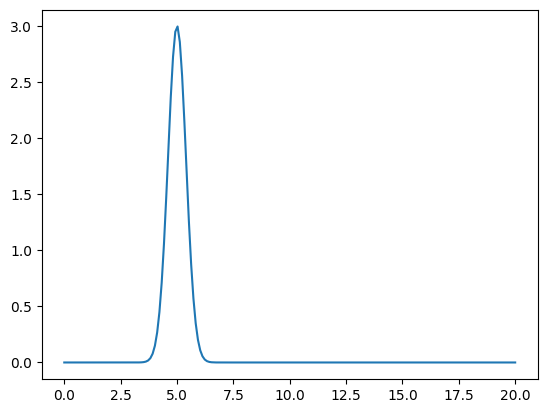

In [52]:
## parameters:
L = 20.0
c = 1.0

## IC
sigma = 0.4
amplitude = 3.0
x0 = L/4
t_final = 5

## discretization stuff:
nx = 200
dx = L / (nx - 1)

dt = .2*dx/c
nt = int(t_final/dt) + 1


t = np.linspace(0, t_final, nt)

##

## arrays and such:
x = np.linspace(0, L, nx)
t = np.linspace(0, t_final, nt)

u = np.zeros((nt, nx)) 


u[0,:] = amplitude*np.exp(-(x-x0)**2/(2*sigma**2))

# Apply periodic boundary conditions
u[0, 0] = u[0,-2]
u[0, -1] = u[0, 1]
u[0,:]

plt.plot(x, u[0,:])

In [53]:
for j in range(0, nt-1):
    # we need arrays for each k stage:
    k1 = np.zeros(nx)
    k2 = np.zeros(nx)
    k3 = np.zeros(nx)
    k4 = np.zeros(nx)

    for i in range(1, nx-1):
        k1[i] =  -c * (u[j, i] - u[j, i-1]) / dx
    
    # k2s:
    u_temp = u[j,:] + (dt/2)*k1
    u_temp[0] = u_temp[-2] # periodic
    u_temp[-1] = u_temp[1]
    for i in range(1, nx-1):
        k2[i] =  -c * (u_temp[i] - u_temp[i-1]) / dx

    # k3s:
    u_temp = u[j,:] + (dt/2)*k2
    u_temp[0] = u_temp[-2] # periodic
    u_temp[-1] = u_temp[1]
    for i in range(1, nx-1):
        k3[i] =  -c * (u_temp[i] - u_temp[i-1]) / dx
    
    # k4s:
    u_temp = u[j, :] + dt * k3
    u_temp[0] = u_temp[-2] # periodic
    u_temp[-1] = u_temp[1]
    for i in range(1, nx-1):
        k4[i] = -c * (u_temp[i] - u_temp[i-1]) / dx
    
    u[j+1, :] = u[j, :] + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
    u[j+1, 0] = u[j+1, -2] # periodic
    u[j+1, -1] = u[j+1, 1]

    if j % 100 == 0:
        total_mass = np.sum(u[j, 1:-1]) * dx  # Only interior points
        print(f"j={j}, total mass={total_mass:.4f}")


j=0, total mass=3.0080
j=100, total mass=3.0080
j=200, total mass=3.0080


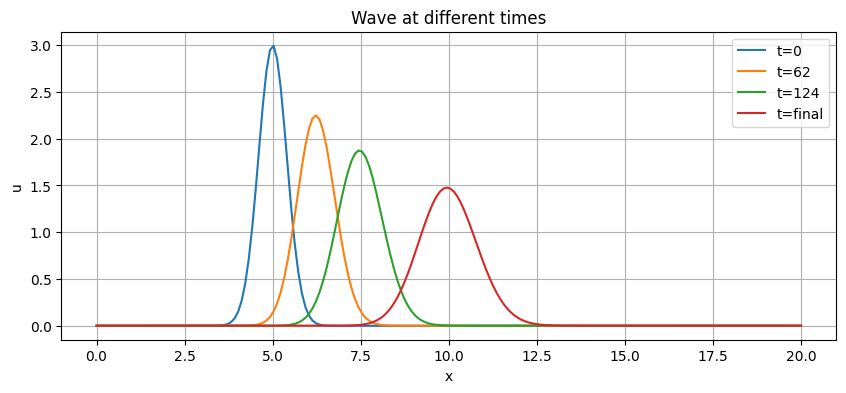

In [54]:

# Plot a few time snapshots
plt.figure(figsize=(10, 4))
plt.plot(x, u[0, :], label='t=0')
plt.plot(x, u[nt//4, :], label=f't={nt//4}')
plt.plot(x, u[nt//2, :], label=f't={nt//2}')
plt.plot(x, u[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('Wave at different times')
plt.show()

In [55]:
t0_peak_height = np.max(u[0,:])

In [56]:
max_heights = np.zeros(nt)
for j in range(nt):
    max_heights[j] = np.max(u[j,:])

Text(0.5, 1.0, 'Peak height error over time')

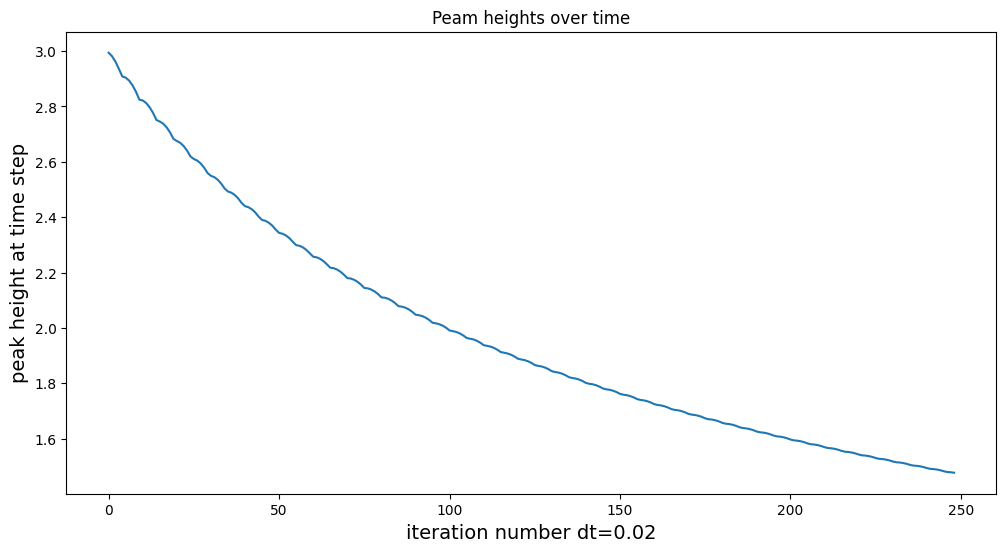

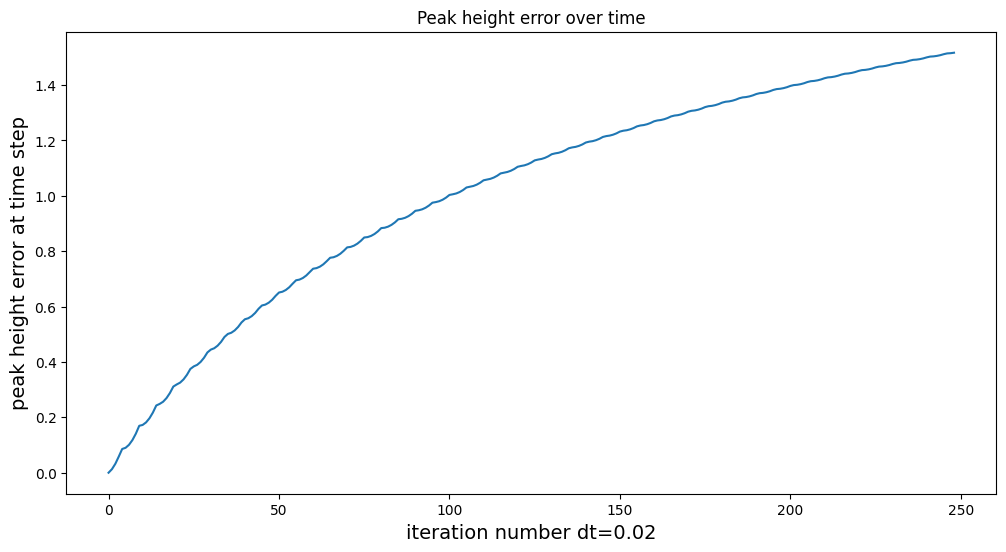

In [57]:
plt.figure(figsize=(12,6))
plt.plot(max_heights)
plt.xlabel(f'iteration number dt={round(dt,3)}', fontsize=14)
plt.ylabel(f'peak height at time step', fontsize = 14)
plt.title('Peam heights over time')


plt.figure(figsize=(12,6))
plt.plot(np.abs(t0_peak_height-max_heights))
plt.xlabel(f'iteration number dt={round(dt,3)}', fontsize=14)
plt.ylabel(f'peak height error at time step', fontsize = 14)
plt.title('Peak height error over time')



In [58]:
def exact_solution(x, t_val, c, sigma, amplitude, x0_init):
    """Exact solution: shifted Gaussian"""
    center = x0_init + c * t_val  # Center moves with velocity c
    return amplitude * np.exp(-((x - center)**2) / (2*sigma**2))

def compute_width(u_slice, x):
    """Width (standard deviation)"""
    total = np.sum(u_slice)
    if total < 1e-10:
        return 0
    x_mean = np.sum(x * u_slice) / total
    variance = np.sum((x - x_mean)**2 * u_slice) / total
    return np.sqrt(variance)

# Compute all metrics
peak_heights = np.zeros(nt)
widths = np.zeros(nt)
L2_errors = np.zeros(nt)
total_mass = np.zeros(nt)


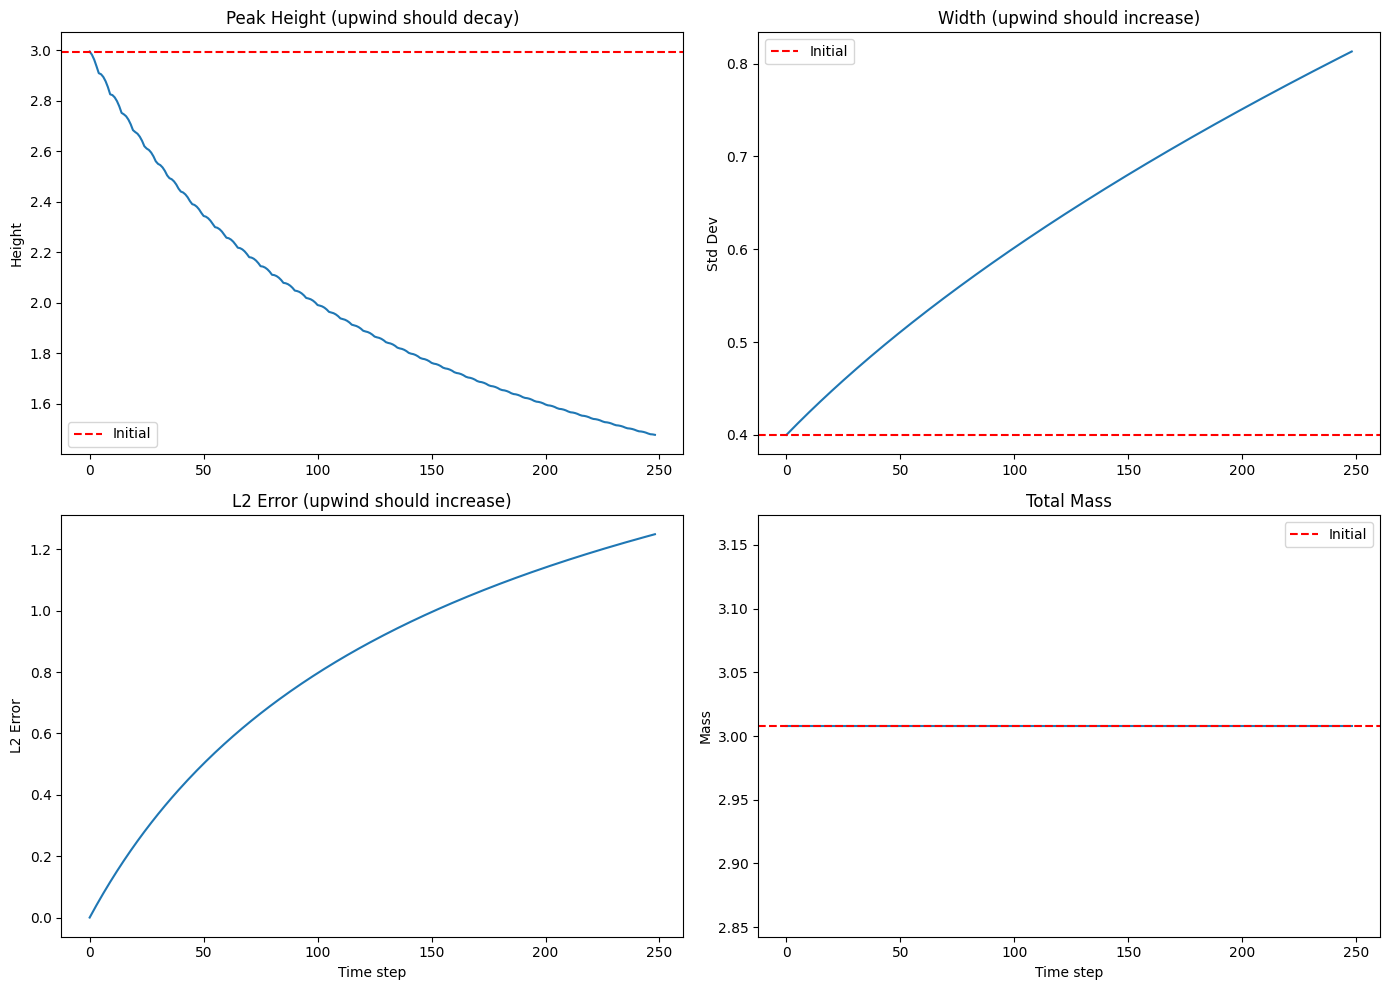

In [59]:

for j in range(nt):
    peak_heights[j] = np.max(u[j,:])
    widths[j] = compute_width(u[j,:], x)
    u_exact = exact_solution(x, t[j], c, sigma, amplitude, x0)
    L2_errors[j] = np.sqrt(dx * np.sum((u[j,:] - u_exact)**2))
    total_mass[j] = np.sum(u[j, 1:-1]) * dx  # Exclude boundaries

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0,0].plot(peak_heights)
axes[0,0].axhline(peak_heights[0], color='r', linestyle='--', label='Initial')
axes[0,0].set_title('Peak Height (upwind should decay)')
axes[0,0].set_ylabel('Height')
axes[0,0].legend()

axes[0,1].plot(widths)
axes[0,1].axhline(widths[0], color='r', linestyle='--', label='Initial')
axes[0,1].set_title('Width (upwind should increase)')
axes[0,1].set_ylabel('Std Dev')
axes[0,1].legend()

axes[1,0].plot(L2_errors)
axes[1,0].set_title('L2 Error (upwind should increase)')
axes[1,0].set_ylabel('L2 Error')
axes[1,0].set_xlabel('Time step')

axes[1,1].plot(total_mass)
axes[1,1].axhline(total_mass[0], color='r', linestyle='--', label='Initial')
axes[1,1].set_title('Total Mass')
axes[1,1].set_ylabel('Mass')
axes[1,1].set_xlabel('Time step')
axes[1,1].legend()

plt.tight_layout()

## FTCS (i know it will fail)

$$u^{j+1}_i = u_i^j + \frac{\Delta t}{2 \Delta x}(u^j_{i+1} - u^j_{i-1})$$

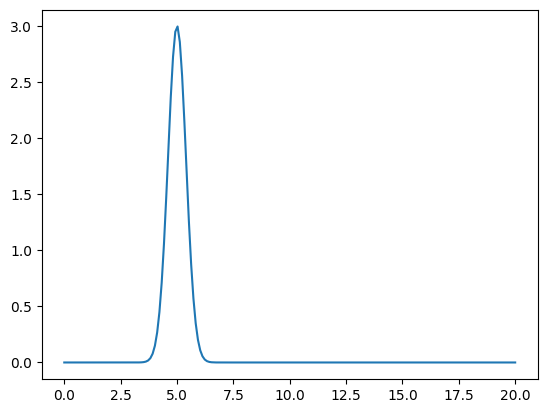

In [60]:
## parameters:
L = 20.0
c = 1.0

## IC
sigma = 0.4
amplitude = 3.0
x0 = L/4
t_final = 5

## discretization stuff:
nx = 200
dx = L / (nx - 1)

dt = .2*dx/c
nt = int(t_final/dt) + 1


t = np.linspace(0, t_final, nt)

##

## arrays and such:
x = np.linspace(0, L, nx)
t = np.linspace(0, t_final, nt)

u_FTCS = np.zeros((nt, nx)) 


u_FTCS[0,:] = amplitude*np.exp(-(x-x0)**2/(2*sigma**2))

# Apply periodic boundary conditions
u_FTCS[0, 0] = u_FTCS[0,-2]
u_FTCS[0, -1] = u_FTCS[0, 1]
u_FTCS[0,:]

plt.plot(x, u_FTCS[0,:])

In [61]:
for j in range(0, nt-1):
    for i in range(1, nx-1):
        u_FTCS[j+1, i] = u_FTCS[j, i] - (c*dt)/(2*dx) * (u_FTCS[j, i+1] - u_FTCS[j, i-1])

    #periodic BCs:
    u_FTCS[j+1, 0] = u_FTCS[j+1, -2]
    u_FTCS[j+1, -1] = u_FTCS[j+1, 1]


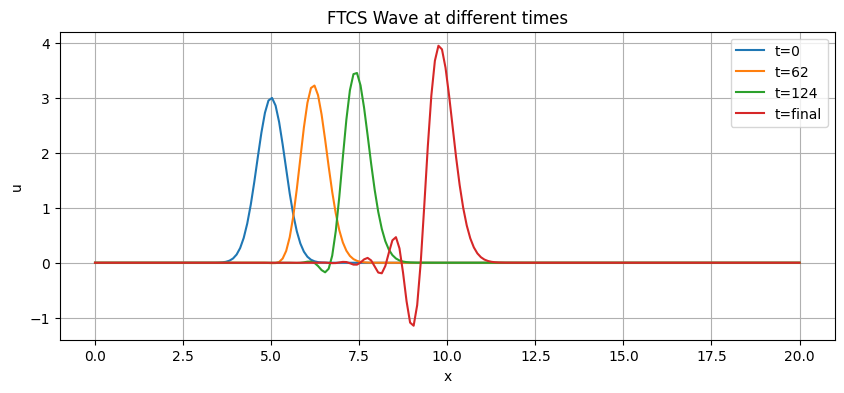

In [62]:

# Plot a few time snapshots
plt.figure(figsize=(10, 4))
plt.plot(x, u_FTCS[0, :], label='t=0')
plt.plot(x, u_FTCS[nt//4, :], label=f't={nt//4}')
plt.plot(x, u_FTCS[nt//2, :], label=f't={nt//2}')
plt.plot(x, u_FTCS[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('FTCS Wave at different times')
plt.show()

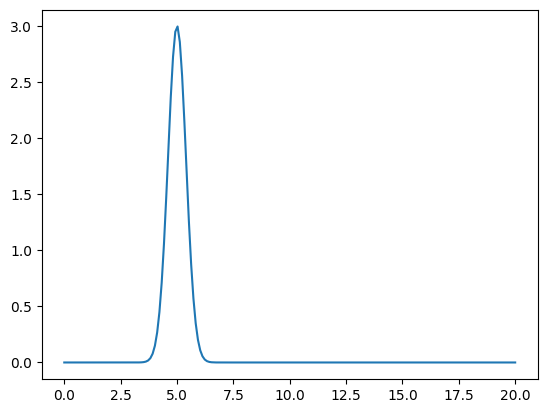

In [63]:
## parameters:
L = 20.0
c = 1.0

## IC
sigma = 0.4
amplitude = 3.0
x0 = L/4
t_final = 5

## discretization stuff:
nx = 200
dx = L / (nx - 1)

dt = 0.2*dx/c
nt = int(t_final/dt) + 1


t = np.linspace(0, t_final, nt)

##

## arrays and such:
x = np.linspace(0, L, nx)
t = np.linspace(0, t_final, nt)

u_2nd_order = np.zeros((nt, nx)) 


u_2nd_order[0,:] = amplitude*np.exp(-(x-x0)**2/(2*sigma**2))

# Apply periodic boundary conditions
u_2nd_order[0, 0] = u_2nd_order[0,-2]
u_2nd_order[0, -1] = u_2nd_order[0, 1]
u_2nd_order[0,:]

plt.plot(x, u_2nd_order[0,:])

In [64]:
for j in range(0, nt-1):
    # we need arrays for each k stage:
    k1 = np.zeros(nx)
    k2 = np.zeros(nx)
    k3 = np.zeros(nx)
    k4 = np.zeros(nx)

    for i in range(1, nx-1):
        if i ==1:
            k1[i] =  -c * (u_2nd_order[j, i] - u_2nd_order[j, i-1]) / dx
        else:
            k1[i] =  -c * (3*u_2nd_order[j, i] - 4*u_2nd_order[j, i-1] + u_2nd_order[j,i-2]) / (2*dx)
    
    # k2s:
    u_temp = u_2nd_order[j,:] + (dt/2)*k1
    u_temp[0] = u_temp[-2] # periodic
    u_temp[-1] = u_temp[1]
    for i in range(1, nx-1):
        if i == 1:
            k2[i] =  -c * (u_temp[i] - u_temp[i-1]) / dx
        else:
            k2[i] = -c * (3*u_temp[i] - 4*u_temp[i-1] + u_temp[i-2]) / (2*dx)

    # k3s:
    u_temp = u_2nd_order[j,:] + (dt/2)*k2
    u_temp[0] = u_temp[-2] # periodic
    u_temp[-1] = u_temp[1]
    for i in range(1, nx-1):
        if i == 1:
            k3[i] =  -c * (u_temp[i] - u_temp[i-1]) / dx
        else:
            k3[i] = -c * (3*u_temp[i] - 4*u_temp[i-1] + u_temp[i-2]) / (2*dx)
    
    # k4s:
    u_temp = u_2nd_order[j, :] + dt * k3
    u_temp[0] = u_temp[-2] # periodic
    u_temp[-1] = u_temp[1]
    for i in range(1, nx-1):
        if i == 1:
            k4[i] =  -c * (u_temp[i] - u_temp[i-1]) / dx
        else:
            k4[i] = -c * (3*u_temp[i] - 4*u_temp[i-1] + u_temp[i-2]) / (2*dx)
    
    u_2nd_order[j+1, :] = u_2nd_order[j, :] + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
    u_2nd_order[j+1, 0] = u_2nd_order[j+1, -2] # periodic
    u_2nd_order[j+1, -1] = u_2nd_order[j+1, 1]

    if j % 100 == 0:
        total_mass = np.sum(u_2nd_order[j, 1:-1]) * dx  # Only interior points
        print(f"j={j}, total mass={total_mass:.4f}")


j=0, total mass=3.0080
j=100, total mass=3.0080
j=200, total mass=3.0080


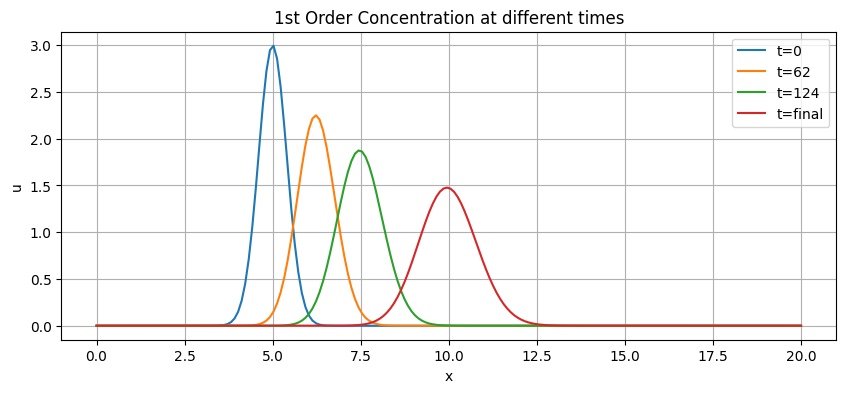

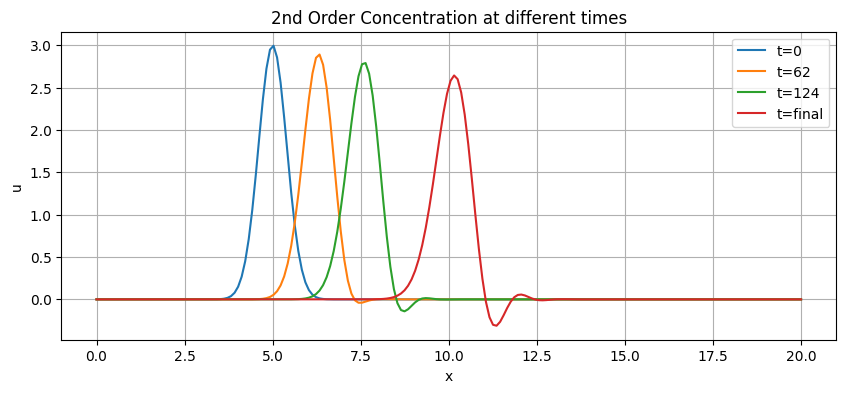

In [65]:

# Plot a few time snapshots
plt.figure(figsize=(10, 4))
plt.plot(x, u[0, :], label='t=0')
plt.plot(x, u[nt//4, :], label=f't={nt//4}')
plt.plot(x, u[nt//2, :], label=f't={nt//2}')
plt.plot(x, u[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('1st Order Concentration at different times')
plt.show()


# Plot a few time snapshots
plt.figure(figsize=(10, 4))
plt.plot(x, u_2nd_order[0, :], label='t=0')
plt.plot(x, u_2nd_order[nt//4, :], label=f't={nt//4}')
plt.plot(x, u_2nd_order[nt//2, :], label=f't={nt//2}')
plt.plot(x, u_2nd_order[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('2nd Order Concentration at different times')
plt.show()